In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
#import src.visuals as vs
from matplotlib import pyplot as plt
#from IPython.display import display # Allows the use of display() for DataFrames
from scipy.stats import norm
# Import supplementary visualizations code visuals.py
#import lightgbm as lgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#from lightgbm.sklearn import LGBMClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,fbeta_score,make_scorer,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import pickle

from sklearn.externals import joblib
seed = 3

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
bc = pd.read_csv('data/branded_content_events.csv')
ai = pd.read_csv('data/app_install_events.csv')
ck = pd.read_csv('data/checkout_events.csv')

### data quality check

In [3]:
bc.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024077 entries, 0 to 2024076
Data columns (total 4 columns):
platform         2024077 non-null object
campaign_name    2024077 non-null object
event_time       2024077 non-null int64
uid              2024077 non-null object
dtypes: int64(1), object(3)
memory usage: 61.8+ MB


In [4]:
bc['uid'].nunique()

1690513

In [5]:
bc = bc.drop_duplicates()

In [6]:
bc.rename(columns={'event_time': 'ad_event_time'}, inplace=True)

In [7]:
bc.shape

(2023418, 4)

### EDA

In [8]:
bc['ad_event_time'] = pd.to_datetime(bc['ad_event_time'],unit='s')
bc['ad_event_date'] = bc['ad_event_time'].dt.date

In [9]:
bc.head()

,platform,campaign_name,ad_event_time,uid,ad_event_date
0,iPhone,author_88,2019-03-01 00:00:00,15a862,2019-03-01
1,iPhone,author_219,2019-03-01 00:00:01,0a9627,2019-03-01
2,iPhone,author_88,2019-03-01 00:00:02,073ae4,2019-03-01
3,iPhone,author_88,2019-03-01 00:00:04,12aff3,2019-03-01
4,iPhone,author_88,2019-03-01 00:00:04,1a0528,2019-03-01


In [10]:
bc['ad_dow'] = bc['ad_event_time'].dt.dayofweek

In [11]:
bc['ad_hour'] = bc['ad_event_time'].dt.hour

In [12]:
ad_cnt = bc.groupby('ad_event_date')['uid'].count().reset_index().sort_values(by='ad_event_date')

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of ads')

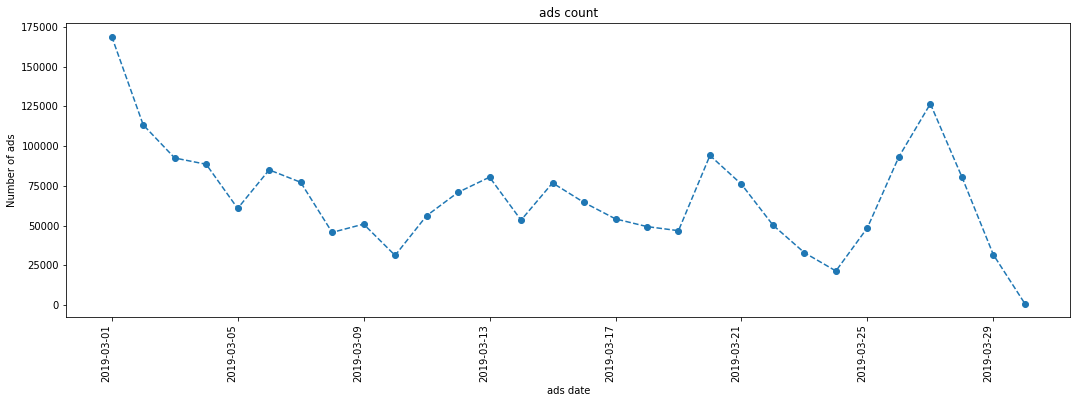

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(ad_cnt['ad_event_date'],ad_cnt['uid'],'o--')
ax.set_title('ads count')
ax.set_xlabel('ads date')
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Number of ads')

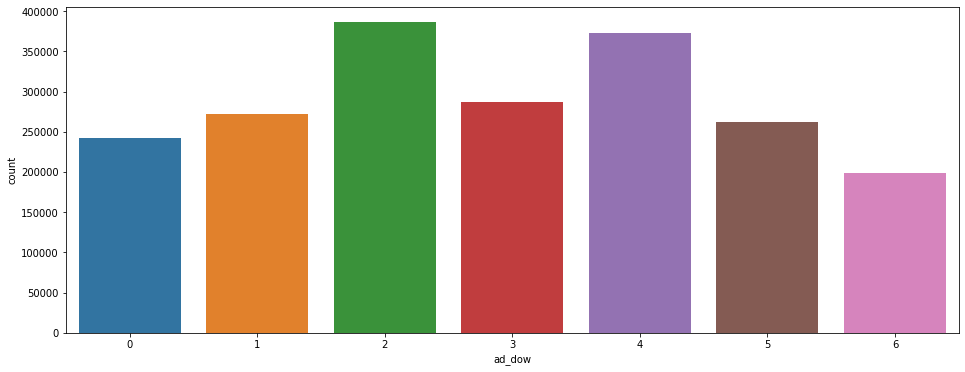

In [14]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="ad_dow", data=bc)

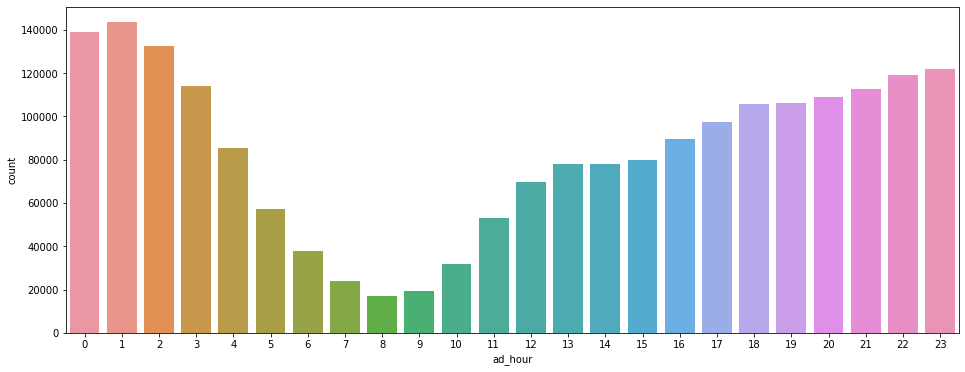

In [15]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="ad_hour", data=bc)

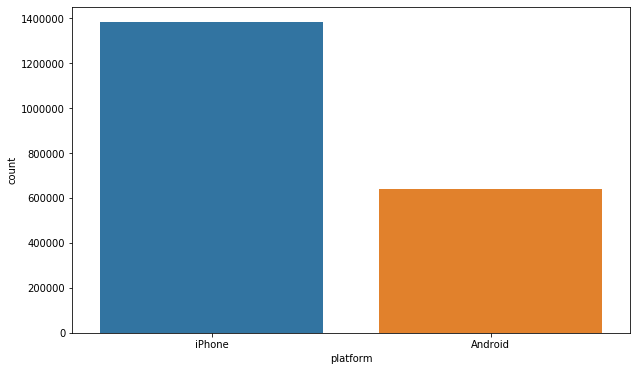

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="platform", data=bc)

In [17]:
top_ten_list = bc['campaign_name'].value_counts().nlargest(10).index.tolist()

In [18]:
bc['campaign_name_std'] = np.where(bc['campaign_name'].isin(top_ten_list),bc['campaign_name'],'non_top_ten')

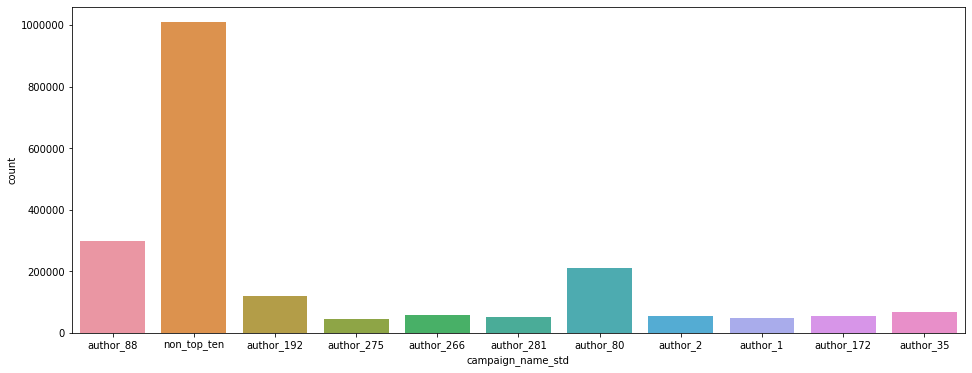

In [19]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="campaign_name_std", data=bc)

In [20]:
bc['campaign_name'].nunique()

281

In [21]:
### App Install

In [22]:
ai.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143149 entries, 0 to 143148
Data columns (total 5 columns):
uid           62213 non-null object
device_id     143149 non-null object
event_time    143149 non-null int64
article_id    62213 non-null float64
source        143149 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 5.5+ MB


In [23]:
ai = ai.drop_duplicates()

In [24]:
ai.rename(columns={'event_time': 'ai_event_time'}, inplace=True)

In [25]:
ai.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143146 entries, 0 to 143148
Data columns (total 5 columns):
uid              62212 non-null object
device_id        143146 non-null object
ai_event_time    143146 non-null int64
article_id       62212 non-null float64
source           143146 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 6.6+ MB


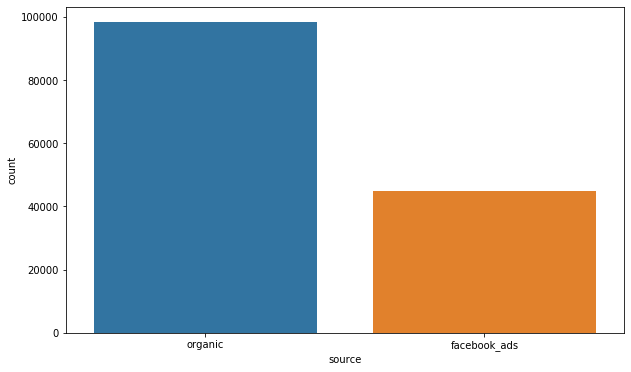

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="source", data=ai)

In [27]:
ai['ai_event_time'] = pd.to_datetime(ai['ai_event_time'],unit='s')
ai['ai_event_date'] = ai['ai_event_time'].dt.date
ai['ai_dow'] = ai['ai_event_time'].dt.dayofweek
ai['ai_hour'] = ai['ai_event_time'].dt.hour

In [28]:
ai_cnt = ai.groupby('ai_event_date').size().to_frame('ai_cnt').reset_index().sort_values(by='ai_event_date')

Text(0, 0.5, 'Number of ads')

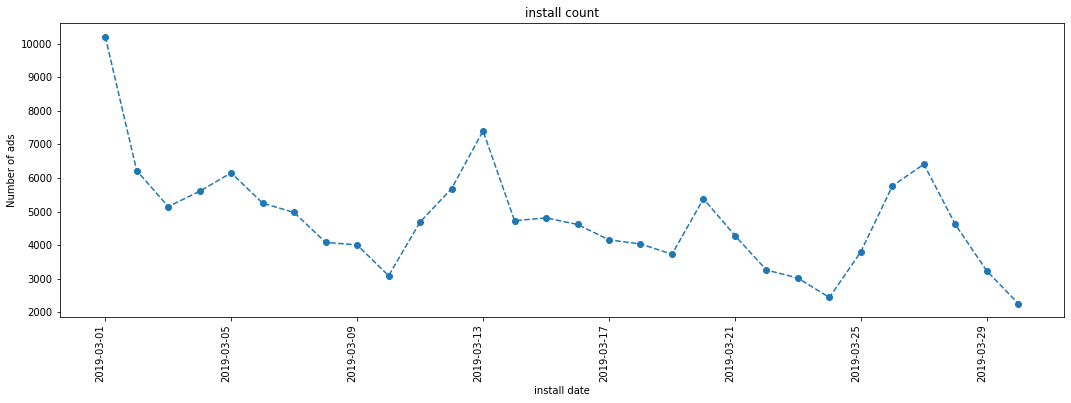

In [29]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(ai_cnt['ai_event_date'],ai_cnt['ai_cnt'],'o--')
ax.set_title('install count')
ax.set_xlabel('install date')
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Number of ads')

In [30]:
ai_uid_isnull = ai[ai['uid'].isnull()]
ai_uid_notnull = ai[ai['uid'].notnull()]

In [31]:
ai_uid_isnull.describe()

,article_id,ai_dow,ai_hour
count,0.0,80934.000000,80934.000000
mean,NaN,2.999283,12.187746
std,NaN,1.932088,7.504729
min,NaN,0.000000,0.000000
25%,NaN,1.000000,4.000000
50%,NaN,3.000000,14.000000
75%,NaN,5.000000,18.000000
max,NaN,6.000000,23.000000


In [32]:
ai_uid_notnull.describe()

,article_id,ai_dow,ai_hour
count,62212.000000,62212.000000,62212.000000
mean,4156.216807,2.822253,11.735003
std,791.619978,1.832151,7.799330
min,3047.000000,0.000000,0.000000
25%,3405.000000,1.000000,3.000000
50%,4130.000000,3.000000,13.000000
75%,4834.000000,4.000000,19.000000
max,5596.000000,6.000000,23.000000


In [33]:
ai_uid_notnull['article_id'] = ai_uid_notnull['article_id'].astype(int)

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
ai_uid_notnull['article_id'].value_counts()

3172    10606
3505     3293
5335     2806
4656     1904
5077     1788
        ...  
4301        1
4397        1
4429        1
4557        1
4146        1
Name: article_id, Length: 2550, dtype: int64

In [35]:
article_top_ten_list = ai_uid_notnull['article_id'].value_counts().nlargest(10).index.tolist()
ai_uid_notnull['article_id_std'] = np.where(ai_uid_notnull['article_id'].isin(article_top_ten_list),ai_uid_notnull['article_id'],'non_top_ten')

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


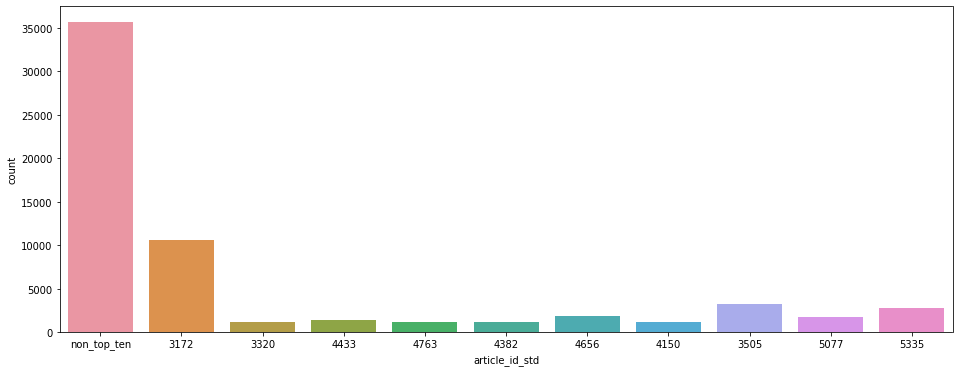

In [36]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="article_id_std", data=ai_uid_notnull)

In [37]:
### checkout

In [38]:
ck.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17334 entries, 0 to 17333
Data columns (total 4 columns):
device_id          17186 non-null object
checkout_time      17334 non-null int64
checkout_status    17334 non-null object
trial_converted    16303 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 541.8+ KB


In [39]:
ck = ck.drop_duplicates()

In [40]:
ck['checkout_time'] = pd.to_datetime(ck['checkout_time'],unit='s')

In [41]:
ck.head()

,device_id,checkout_time,checkout_status,trial_converted
0,be6-8d92a4-15483,2019-03-09 14:56:59,trial_started,1.0
1,be6-8d92a4-0a029,2019-03-13 13:33:58,trial_started,1.0
2,be6-8d92a4-0a851,2019-03-14 18:58:01,trial_started,1.0
3,be6-8d92a4-13f97,2019-03-29 04:56:48,trial_started,1.0
4,be6-8d92a4-1269e,2019-03-07 17:38:20,trial_started,1.0


In [42]:
ck.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17333 entries, 0 to 17333
Data columns (total 4 columns):
device_id          17186 non-null object
checkout_time      17333 non-null datetime64[ns]
checkout_status    17333 non-null object
trial_converted    16302 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 677.1+ KB


# What can you tell us about the effectiveness of our ad campaigns in terms of generating paid subscriptions?

In [43]:
uid_bc_lst = list(bc['uid'].unique())

In [44]:
did_ai_lst = list(ai.loc[ai['uid'].isin(uid_bc_lst),'device_id'].unique())

In [45]:
ck_ad = ck[ck['device_id'].isin(did_ai_lst)]
ck_ad['acquired'] = np.where( (ck_ad['checkout_status'] == 'direct_purchase'), 1, 
         np.where( (ck_ad['checkout_status'] == 'trial_started') & (ck_ad['trial_converted'] == 1), 1, 0) 
        )

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
print('total adtertisement we show in Facebook: ',bc.shape[0])
print('total customers we acquired: ',ck_ad['acquired'].sum())
print('conversion rate: {}%'.format(round(100*ck_ad['acquired'].sum()/bc.shape[0],4)))

total adtertisement we show in Facebook:  2023418
total customers we acquired:  1008
conversion rate: 0.0498%


# What is our general time to acquisition from seeing the ad to getting a paid subscriber? (Assume trial conversion always takes exactly 7 days)

In [47]:
ck_acq = ck_ad[ck_ad['acquired'] == 1].copy()

In [48]:
ck_acq['acquired_type'] = np.where((ck_acq['checkout_status'] == 'direct_purchase'), 'direct', 'through_trial')

In [49]:
ck_acq = ck_acq[['device_id','checkout_time','acquired_type']].copy()

In [50]:
ai_need = ai[['uid','device_id']].drop_duplicates().copy()

In [51]:
bc.columns

Index(['platform', 'campaign_name', 'ad_event_time', 'uid', 'ad_event_date',
       'ad_dow', 'ad_hour', 'campaign_name_std'],
      dtype='object')

In [52]:
bc_need = bc[['uid','ad_event_time']].drop_duplicates().sort_values(by='ad_event_time').drop_duplicates(subset='uid', keep='first')

In [53]:
m1 = pd.merge(ck_acq, ai_need, on='device_id', how='inner')

In [54]:
m2 = pd.merge(m1, bc_need, on='uid', how='inner')

In [55]:
m2.columns

Index(['device_id', 'checkout_time', 'acquired_type', 'uid', 'ad_event_time'], dtype='object')

In [56]:
m2.head()

,device_id,checkout_time,acquired_type,uid,ad_event_time
0,be6-8d92a4-0a029,2019-03-13 13:33:58,through_trial,116184,2019-03-13 13:32:20
1,be6-8d92a4-0a851,2019-03-14 18:58:01,through_trial,18cd91,2019-03-14 18:55:14
2,be6-8d92a4-1291f,2019-03-15 03:38:39,through_trial,04c9b0,2019-03-03 02:37:19
3,be6-8d92a4-03420,2019-03-16 14:36:56,through_trial,12ec30,2019-03-16 14:33:54
4,be6-8d92a4-10f02,2019-03-05 00:20:16,through_trial,183c2e,2019-03-05 00:17:22


In [57]:
#m2['checkout_time'] = pd.to_datetime(m2['checkout_time'])
#m2['ad_event_time'] = pd.to_datetime(m2['ad_event_time'])
m2['day_to_acq'] = m2['checkout_time']-m2['ad_event_time']
m2['day_to_acq'] = m2['day_to_acq'].dt.days

In [58]:
m2

,device_id,checkout_time,acquired_type,uid,ad_event_time,day_to_acq
0,be6-8d92a4-0a029,2019-03-13 13:33:58,through_trial,116184,2019-03-13 13:32:20,0
1,be6-8d92a4-0a851,2019-03-14 18:58:01,through_trial,18cd91,2019-03-14 18:55:14,0
2,be6-8d92a4-1291f,2019-03-15 03:38:39,through_trial,04c9b0,2019-03-03 02:37:19,12
3,be6-8d92a4-03420,2019-03-16 14:36:56,through_trial,12ec30,2019-03-16 14:33:54,0
4,be6-8d92a4-10f02,2019-03-05 00:20:16,through_trial,183c2e,2019-03-05 00:17:22,0
...,...,...,...,...,...,...
1003,be6-8d92a4-07f96,2019-03-25 11:14:52,direct,09853c,2019-03-25 11:12:37,0
1004,be6-8d92a4-1d057,2019-03-23 15:31:04,direct,03d87f,2019-03-23 15:24:49,0
1005,be6-8d92a4-199ae,2019-03-18 11:47:56,direct,05ced7,2019-03-12 02:17:23,6
1006,be6-8d92a4-0f363,2019-03-28 17:04:47,direct,0144eb,2019-03-26 06:14:55,2


In [59]:
m2['day_to_acq'] = np.where(m2['acquired_type'] == 'through_trial', m2['day_to_acq'] + 7, m2['day_to_acq'])

In [60]:
m2['day_to_acq'].mean()

8.490079365079366

In [61]:
m2[m2['day_to_acq'] < 0]

,device_id,checkout_time,acquired_type,uid,ad_event_time,day_to_acq


In [62]:
cnt_map = bc.groupby('uid')['ad_event_time'].size()
bc['contact_times'] = bc['uid'].map(cnt_map)

In [63]:
bc['contact_times'].max()

49

In [64]:
check = bc[bc['contact_times'] == 49]

In [65]:
contacts = bc[['uid','contact_times']].drop_duplicates()

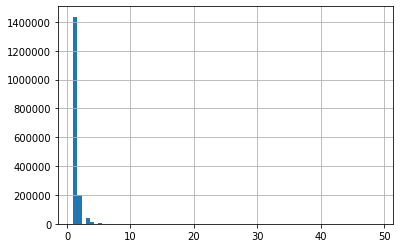

In [66]:
contacts['contact_times'].hist(bins=75)

### modeling prep

In [67]:
bc.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023418 entries, 0 to 2024076
Data columns (total 9 columns):
platform             2023418 non-null object
campaign_name        2023418 non-null object
ad_event_time        2023418 non-null datetime64[ns]
uid                  2023418 non-null object
ad_event_date        2023418 non-null object
ad_dow               2023418 non-null int64
ad_hour              2023418 non-null int64
campaign_name_std    2023418 non-null object
contact_times        2023418 non-null int64
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 154.4+ MB


In [68]:
minima = bc.groupby('uid')['ad_event_time'].min()
bc['min_event'] = bc['uid'].map(minima)

In [69]:
bc_need = bc[bc['min_event'] == bc['ad_event_time']].copy()

In [70]:
bc_need

,platform,campaign_name,ad_event_time,uid,ad_event_date,ad_dow,ad_hour,campaign_name_std,contact_times,min_event
0,iPhone,author_88,2019-03-01 00:00:00,15a862,2019-03-01,4,0,author_88,1,2019-03-01 00:00:00
1,iPhone,author_219,2019-03-01 00:00:01,0a9627,2019-03-01,4,0,non_top_ten,1,2019-03-01 00:00:01
2,iPhone,author_88,2019-03-01 00:00:02,073ae4,2019-03-01,4,0,author_88,1,2019-03-01 00:00:02
3,iPhone,author_88,2019-03-01 00:00:04,12aff3,2019-03-01,4,0,author_88,2,2019-03-01 00:00:04
4,iPhone,author_88,2019-03-01 00:00:04,1a0528,2019-03-01,4,0,author_88,1,2019-03-01 00:00:04
...,...,...,...,...,...,...,...,...,...,...
2024070,iPhone,author_147,2019-03-30 22:02:54,13b5ab,2019-03-30,5,22,non_top_ten,1,2019-03-30 22:02:54
2024071,iPhone,author_147,2019-03-30 22:11:31,145f14,2019-03-30,5,22,non_top_ten,2,2019-03-30 22:11:31
2024073,iPhone,author_147,2019-03-30 22:45:36,16b38a,2019-03-30,5,22,non_top_ten,1,2019-03-30 22:45:36
2024075,iPhone,author_219,2019-03-30 23:23:48,099086,2019-03-30,5,23,non_top_ten,1,2019-03-30 23:23:48


In [71]:
need_cols = ['uid','ad_dow','ad_hour','contact_times','campaign_name_std','platform']

In [72]:
part1 = bc_need[need_cols].copy()

In [73]:
### part2

In [74]:
ai_uid_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62212 entries, 1 to 143109
Data columns (total 9 columns):
uid               62212 non-null object
device_id         62212 non-null object
ai_event_time     62212 non-null datetime64[ns]
article_id        62212 non-null int64
source            62212 non-null object
ai_event_date     62212 non-null object
ai_dow            62212 non-null int64
ai_hour           62212 non-null int64
article_id_std    62212 non-null object
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 7.2+ MB


In [75]:
ai_uid_notnull['uid'].nunique()

61805

In [76]:
ai_uid_notnull[['uid','device_id']].drop_duplicates().shape

(62181, 2)

In [77]:
ai_need = ai_uid_notnull.sort_values(by='ai_event_time').drop_duplicates(subset=['uid','device_id'], keep='first')

In [80]:
need_cols = ['uid','device_id','source','ai_dow','ai_hour','article_id_std']

In [81]:
part2 = ai_need[need_cols].copy()

In [82]:
### part3

In [83]:
part1

,uid,ad_dow,ad_hour,contact_times,campaign_name_std,platform
0,15a862,4,0,1,author_88,iPhone
1,0a9627,4,0,1,non_top_ten,iPhone
2,073ae4,4,0,1,author_88,iPhone
3,12aff3,4,0,2,author_88,iPhone
4,1a0528,4,0,1,author_88,iPhone
...,...,...,...,...,...,...
2024070,13b5ab,5,22,1,non_top_ten,iPhone
2024071,145f14,5,22,2,non_top_ten,iPhone
2024073,16b38a,5,22,1,non_top_ten,iPhone
2024075,099086,5,23,1,non_top_ten,iPhone


In [84]:
part2

,uid,device_id,source,ai_dow,ai_hour,article_id_std
852,0248b3,be6-8d92a4-0f239,facebook_ads,4,0,3172
853,15dcf1,be6-8d92a4-0fc5f,facebook_ads,4,0,non_top_ten
854,0fe17f,be6-8d92a4-0034e,facebook_ads,4,0,3172
10861,114b04,be6-8d92a4-13ba5,facebook_ads,4,0,3172
4377,0517ea,be6-8d92a4-231e1,facebook_ads,4,0,3172
...,...,...,...,...,...,...
142795,082d72,be6-8d92a4-16b79,facebook_ads,5,23,4382
142809,03dfe0,be6-8d92a4-00c5e,organic,5,23,non_top_ten
142956,117f72,be6-8d92a4-17435,organic,5,23,non_top_ten
142816,1208f2,be6-8d92a4-2242c,facebook_ads,5,23,non_top_ten


In [85]:
converted_device_id_lst = list(ck_acq['device_id'].unique())

In [86]:
part2['converted'] = np.where(part2['device_id'].isin(converted_device_id_lst),1,0)

In [87]:
t = pd.merge(part1,part2,on='uid',how='left')

In [88]:
t['app_converted'] = np.where(t['device_id'].isnull(),0,1)

In [89]:
t['converted'] = t['converted'].fillna(0)

In [90]:
t['converted'].mean()

0.0005949884935376324

In [91]:
t['app_converted'].mean()

0.025479228928033008

In [92]:
t

,uid,ad_dow,ad_hour,contact_times,campaign_name_std,platform,device_id,source,ai_dow,ai_hour,article_id_std,converted,app_converted
0,15a862,4,0,1,author_88,iPhone,NaN,NaN,NaN,NaN,NaN,0.0,0
1,0a9627,4,0,1,non_top_ten,iPhone,NaN,NaN,NaN,NaN,NaN,0.0,0
2,073ae4,4,0,1,author_88,iPhone,NaN,NaN,NaN,NaN,NaN,0.0,0
3,12aff3,4,0,2,author_88,iPhone,NaN,NaN,NaN,NaN,NaN,0.0,0
4,1a0528,4,0,1,author_88,iPhone,NaN,NaN,NaN,NaN,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690784,13b5ab,5,22,1,non_top_ten,iPhone,NaN,NaN,NaN,NaN,NaN,0.0,0
1690785,145f14,5,22,2,non_top_ten,iPhone,NaN,NaN,NaN,NaN,NaN,0.0,0
1690786,16b38a,5,22,1,non_top_ten,iPhone,be6-8d92a4-1c0c0,facebook_ads,5.0,22.0,non_top_ten,0.0,1
1690787,099086,5,23,1,non_top_ten,iPhone,NaN,NaN,NaN,NaN,NaN,0.0,0


In [ ]:
### first model 

In [101]:
data = t[['ad_dow','ad_hour','contact_times','campaign_name_std','platform','app_converted','converted']]

In [103]:
data['converted'].mean()

0.0005949884935376324

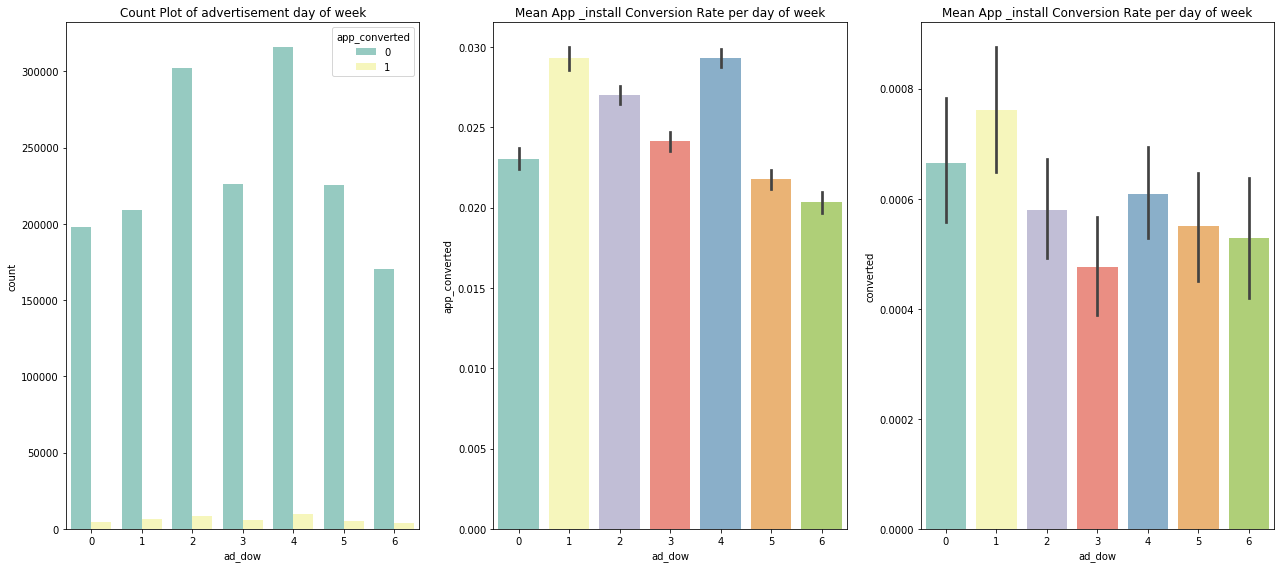

In [104]:
# Visualization of different countries
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='ad_dow', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='ad_dow', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='ad_dow', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

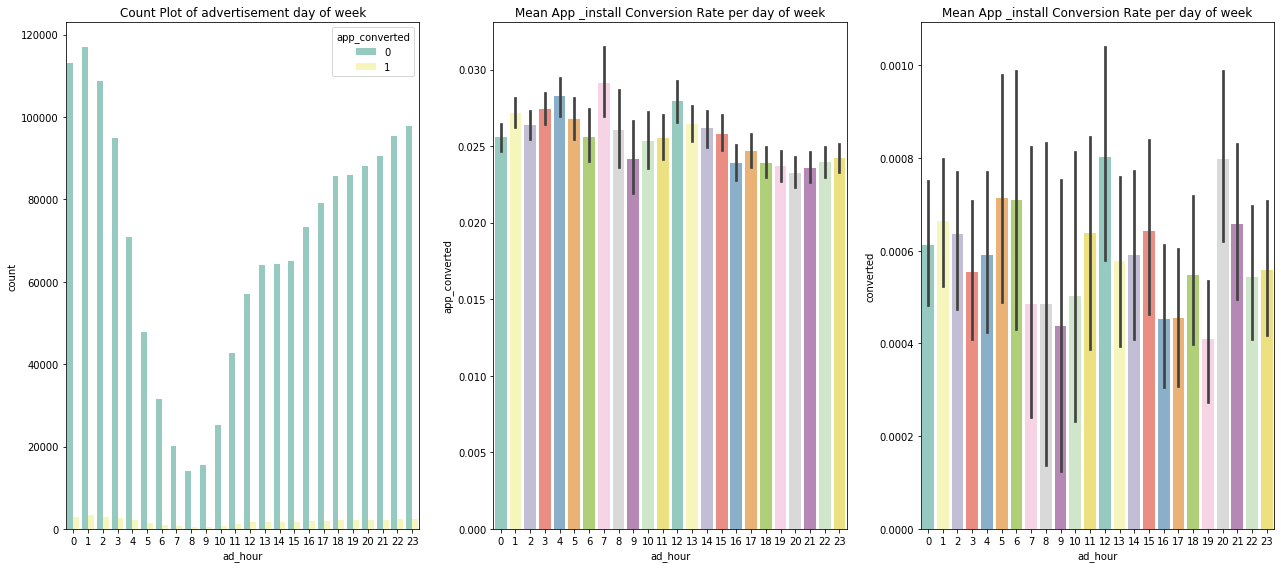

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='ad_hour', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='ad_hour', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='ad_hour', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

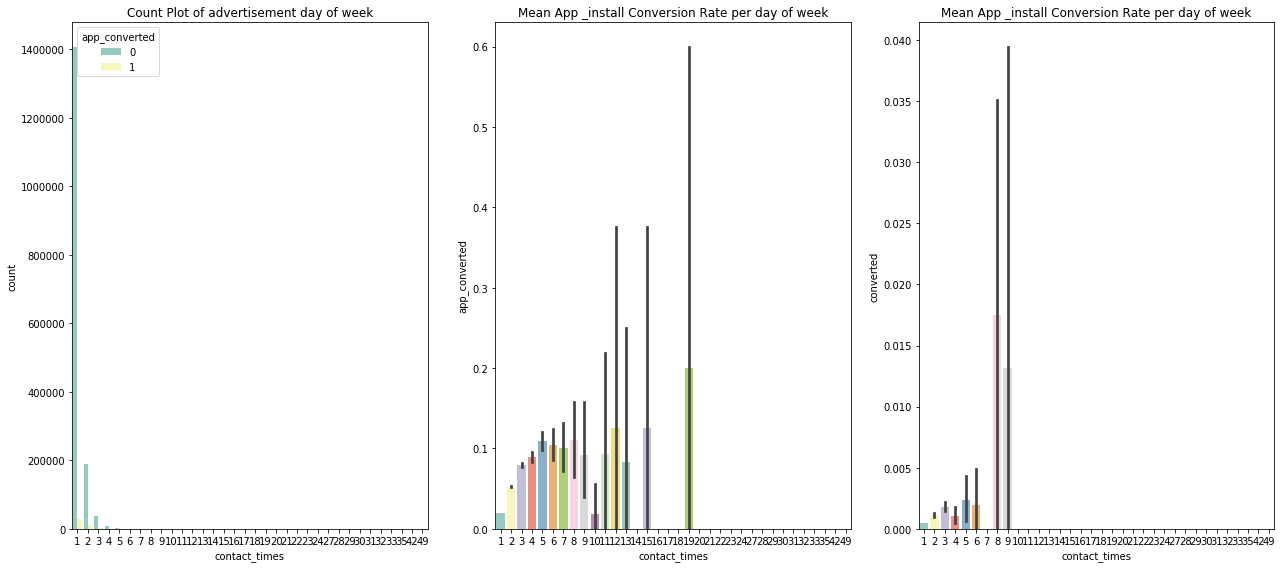

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='contact_times', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='contact_times', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='contact_times', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='platform', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='platform', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='platform', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
'''
#Business goal
We want to expand the spend on the sponsored content strategy while maintaining a level of efficiency. 

#The Questions

-	What can you tell us about the effectiveness of our ad campaigns in terms of generating paid subscriptions?
-	What is our general time to acquisition from seeing the ad to getting a paid subscriber? (Assume trial conversion always takes exactly 7 days)
-	What are the factors that affect the conversion rate to a paid subscription and what do you think that tells us about these visitors?

#Additional Discussion
-	What would you recommend the performance marketing manager do? What would you recommend the product manager do? 
-	What additional information would make this analysis more “complete” or actionable? If given that information and more time, how would that change your analysis?
'''